<a href="https://colab.research.google.com/github/nuriamontala/PYT-SBI/blob/main/model_%26_predictionblackboxDEF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torch_geometric
!pip install graphein

In [13]:
import torch
import torch.nn as nx
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_add_pool
from torch_geometric.data import Data
import graphein.protein as gp
from graphein.protein.config import ProteinGraphConfig
from Bio import PDB
import os
from torch_geometric.data import Data, Dataset
from torch.utils.data import Dataset, random_split, Subset
import pandas as pd
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.edges.distance import (add_peptide_bonds,
                                             add_hydrogen_bond_interactions,
                                             add_disulfide_interactions,
                                             add_ionic_interactions,
                                             add_aromatic_interactions,
                                             add_aromatic_sulphur_interactions,
                                             add_cation_pi_interactions,
                                             add_delaunay_triangulation)

# Edge construction functions
new_edge_funcs = {"edge_construction_functions": [
    add_peptide_bonds,
    add_aromatic_interactions,
    add_hydrogen_bond_interactions,
    add_disulfide_interactions,
    add_ionic_interactions,
    add_aromatic_sulphur_interactions,
    add_cation_pi_interactions,
    add_delaunay_triangulation
]}


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


LOAD RESIDUE FEATURES

In [10]:
from graphein.protein.graphs import construct_graph

# ✅ Load Residue Features from CSV
def load_residue_features(csv_path):
    """Loads residue features and binding site labels from CSV."""
    df = pd.read_csv(csv_path)

    # Convert first column (Residue ID) into tuples (residue_number, chain)
    df.iloc[:, 0] = df.iloc[:, 0].apply(eval)  # Convert string "(1, 'L')" → tuple (1, 'L')

    residue_ids = df.iloc[:, 0]  # Residue ID as tuple
    features = df.iloc[:, 1:-1].values  # Feature columns (excluding label)
    labels = df.iloc[:, -1].values  # Last column = binding site labels

    # Create lookup dictionaries
    features_dict = {res_id: feat for res_id, feat in zip(residue_ids, features)}
    labels_dict = {res_id: label for res_id, label in zip(residue_ids, labels)}

    return features_dict, labels_dict, features.shape[1]  # Return num_features



CONVERT GRAPHEIN TO PYTORCH GEOMETRIC OBJECT

In [12]:
# ✅ Convert NetworkX Graph → PyTorch Geometric Graph
def networkx_to_pyg(G_nx, features_dict, labels_dict, num_features):
    """Converts a NetworkX protein graph to a PyTorch Geometric Data object, removing nodes without features."""
    node_map = {}  # Maps node (residue, chain) to index
    reverse_map = {}  # Reverse lookup: PyG index → (residue_number, chain)
    node_features = []
    y = []
    valid_nodes = set()  # Stores nodes that have valid features

    for i, (node, attr) in enumerate(G_nx.nodes(data=True)):
        res_id = (attr.get("residue_number"), attr.get("chain_id"))  # Standardized format

        # Only include nodes that have valid features
        if res_id not in features_dict:
            continue  # Skip nodes with missing features

        valid_nodes.add(node)
        node_map[node] = len(node_features)  # Assign PyG-compatible node index
        reverse_map[len(node_features)] = res_id  # Store mapping back to residue identifier

        # Retrieve features
        node_features.append(features_dict[res_id])

        # Retrieve binding site labels
        y.append(labels_dict.get(res_id, 0))

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)

    # Extract edges but only keep edges where **both** nodes are in valid_nodes
    edges = []
    for u, v in G_nx.edges():
        if u in valid_nodes and v in valid_nodes:  # Ensure both nodes exist in the filtered set
            edges.append((node_map[u], node_map[v]))

    if not edges:  # If no valid edges, return None (to avoid empty graphs)
        print(f"⚠️ Graph contains no valid edges after filtering. Skipping!")
        return None, None

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index, y=y), reverse_map


PROCESS ALL PDB + CSV FILES IN A FOLDER

In [ ]:
from torch_geometric.data import Dataset

def process_protein_graphs(folder_path, save_path="protein_graphs", start=0, end=500):
    """Processes PDB files in batches of 500 and saves graphs with PDB codes as filenames."""
    os.makedirs(save_path, exist_ok=True)  # Create output folder if it doesn't exist

    # Get all available PDB files
    pdb_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".pdb")])  # Sort for consistency

    # Select a subset (batch of 500)
    pdb_files = pdb_files[start:end]

    for pdb_file in pdb_files:
        pdb_code = pdb_file.replace(".pdb", "")  # Extract PDB code
        pdb_path = os.path.join(folder_path, pdb_file)
        csv_path = os.path.join(folder_path, pdb_code + ".csv")
        graph_file = os.path.join(save_path, f"{pdb_code}.pt")  # Use PDB code as filename

        # ✅ Skip if the graph file already exists (avoid overwriting)
        if os.path.exists(graph_file):
            print(f"⚠️ Graph for {pdb_code} already exists. Skipping!")
            continue

        if not os.path.exists(csv_path):
            print(f"⚠️ Warning: No CSV found for {pdb_file}. Skipping!")
            continue

        print(f"📌 Processing {pdb_file}...")

        # Load features & labels
        features_dict, labels_dict, num_features = load_residue_features(csv_path)

        # Construct NetworkX graph
        config = ProteinGraphConfig(**new_edge_funcs)
        G_nx = construct_graph(config=config, path=pdb_path)

        # Convert to PyG Data object
        protein_graph_data, reverse_map = networkx_to_pyg(G_nx, features_dict, labels_dict, num_features)

        if protein_graph_data:  # Ensure we have a valid graph
            torch.save(protein_graph_data, graph_file)
            print(f"✅ Saved graph as {graph_file}")

    print(f"✅ Batch {start}-{end} processed and saved in {save_path}")

# ✅ Run
process_protein_graphs("testingfiles/testingfiles", start=0, end=500)


Output()

📌 Processing 4p0n.pdb...


<ipython-input-12-850175e8758a>:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x = torch.tensor(node_features, dtype=torch.float)


✅ Processed 4p0n.pdb (615 nodes, 4563 edges)
📌 Processing 4os4.pdb...


Output()

✅ Processed 4os4.pdb (258 nodes, 1834 edges)
📌 Processing 4o42.pdb...


Output()

✅ Processed 4o42.pdb (179 nodes, 1244 edges)
📌 Processing 4oya.pdb...


Output()

✅ Processed 4oya.pdb (467 nodes, 3421 edges)
📌 Processing 4oty.pdb...


Output()

✅ Processed 4oty.pdb (1103 nodes, 8317 edges)
📌 Processing 4p6g.pdb...


Output()

✅ Processed 4p6g.pdb (875 nodes, 6567 edges)
📌 Processing 4oyp.pdb...


Output()

✅ Processed 4oyp.pdb (467 nodes, 3429 edges)
📌 Processing 4nwd.pdb...


Output()

✅ Processed 4nwd.pdb (254 nodes, 1814 edges)
📌 Processing 4pnm.pdb...


Output()

✅ Processed 4pnm.pdb (815 nodes, 6116 edges)
📌 Processing 4od9.pdb...


Output()

✅ Processed 4od9.pdb (675 nodes, 4980 edges)
📌 Processing 4o45.pdb...


Output()

✅ Processed 4o45.pdb (310 nodes, 2190 edges)
📌 Processing 4oz3.pdb...


Output()

✅ Processed 4oz3.pdb (467 nodes, 3429 edges)
📌 Processing 4oas.pdb...


Output()

✅ Processed 4oas.pdb (278 nodes, 1974 edges)
📌 Processing 4nni.pdb...


Output()

✅ Processed 4nni.pdb (322 nodes, 2333 edges)
📌 Processing 4pnw.pdb...


Output()

✅ Processed 4pnw.pdb (728 nodes, 5349 edges)
📌 Processing 4pnc.pdb...


Output()

✅ Processed 4pnc.pdb (262 nodes, 1848 edges)
📌 Processing 4oef.pdb...


Output()

✅ Processed 4oef.pdb (125 nodes, 823 edges)
📌 Processing 4ode.pdb...


Output()

✅ Processed 4ode.pdb (105 nodes, 687 edges)
📌 Processing 4o7f.pdb...


Output()

✅ Processed 4o7f.pdb (254 nodes, 1815 edges)
📌 Processing 4pl0.pdb...


Output()

✅ Processed 4pl0.pdb (1147 nodes, 8658 edges)
📌 Processing 4os5.pdb...


Output()

✅ Processed 4os5.pdb (258 nodes, 1836 edges)
📌 Processing 4o4y.pdb...


Output()

✅ Processed 4o4y.pdb (439 nodes, 3159 edges)
📌 Processing 4pci.pdb...


Output()

✅ Processed 4pci.pdb (126 nodes, 843 edges)
📌 Processing 4nrc.pdb...


Output()

✅ Processed 4nrc.pdb (115 nodes, 767 edges)
📌 Processing 4ovz.pdb...


Output()

✅ Processed 4ovz.pdb (554 nodes, 4112 edges)
📌 Processing 4o74.pdb...


Output()

✅ Processed 4o74.pdb (254 nodes, 1828 edges)
📌 Processing 4nq6.pdb...


Output()

✅ Processed 4nq6.pdb (222 nodes, 1549 edges)
📌 Processing 4pct.pdb...


Output()

✅ Processed 4pct.pdb (1752 nodes, 13375 edges)
📌 Processing 4nms.pdb...


Output()

✅ Processed 4nms.pdb (188 nodes, 1298 edges)
📌 Processing 4oc6.pdb...


Output()

✅ Processed 4oc6.pdb (341 nodes, 2439 edges)
📌 Processing 4ogi.pdb...


Output()

✅ Processed 4ogi.pdb (254 nodes, 1833 edges)
📌 Processing 4os2.pdb...


Output()

✅ Processed 4os2.pdb (257 nodes, 1825 edges)
📌 Processing 4o43.pdb...


Output()

✅ Processed 4o43.pdb (652 nodes, 4876 edges)
📌 Processing 4nxs.pdb...


Output()

✅ Processed 4nxs.pdb (781 nodes, 5848 edges)
📌 Processing 4p0w.pdb...


Output()

✅ Processed 4p0w.pdb (346 nodes, 2514 edges)
📌 Processing 4nie.pdb...


Output()

✅ Processed 4nie.pdb (509 nodes, 3720 edges)
📌 Processing 4oyb.pdb...


Output()

✅ Processed 4oyb.pdb (467 nodes, 3428 edges)
📌 Processing 4phw.pdb...


Output()

✅ Processed 4phw.pdb (610 nodes, 4524 edges)
📌 Processing 4osf.pdb...


Output()

✅ Processed 4osf.pdb (342 nodes, 2461 edges)
📌 Processing 4ob2.pdb...


Output()

✅ Processed 4ob2.pdb (430 nodes, 3160 edges)
📌 Processing 4pm0.pdb...


Output()

✅ Processed 4pm0.pdb (318 nodes, 2272 edges)
📌 Processing 4pf3.pdb...


Output()

✅ Processed 4pf3.pdb (249 nodes, 1756 edges)
📌 Processing 4rt0.pdb...


Output()

✅ Processed 4rt0.pdb (320 nodes, 2309 edges)
📌 Processing 4ps5.pdb...


Output()

✅ Processed 4ps5.pdb (254 nodes, 1817 edges)
📌 Processing 4qtn.pdb...


Output()

✅ Processed 4qtn.pdb (683 nodes, 5094 edges)
📌 Processing 4r5x.pdb...


Output()

✅ Processed 4r5x.pdb (888 nodes, 6688 edges)


Output()

📌 Processing 4q4e.pdb...


Output()

✅ Processed 4q4e.pdb (866 nodes, 6495 edges)
📌 Processing 4qmt.pdb...


Output()

✅ Processed 4qmt.pdb (284 nodes, 2035 edges)
📌 Processing 4qmy.pdb...


Output()

✅ Processed 4qmy.pdb (287 nodes, 2030 edges)
📌 Processing 4rfz.pdb...


Output()

✅ Processed 4rfz.pdb (263 nodes, 1850 edges)
📌 Processing 4qtb.pdb...


Output()

✅ Processed 4qtb.pdb (699 nodes, 5211 edges)
📌 Processing 4r6e.pdb...


Output()

✅ Processed 4r6e.pdb (1398 nodes, 10555 edges)
📌 Processing 4pre.pdb...


Output()

✅ Processed 4pre.pdb (386 nodes, 2815 edges)
📌 Processing 4qqi.pdb...


Output()

✅ Processed 4qqi.pdb (192 nodes, 1326 edges)
📌 Processing 4pov.pdb...


Output()

✅ Processed 4pov.pdb (354 nodes, 2575 edges)
📌 Processing 4qt0.pdb...


Output()

✅ Processed 4qt0.pdb (2651 nodes, 20263 edges)
📌 Processing 4quo.pdb...


Output()

✅ Processed 4quo.pdb (847 nodes, 6347 edges)
📌 Processing 4qxr.pdb...


Output()

✅ Processed 4qxr.pdb (364 nodes, 2634 edges)
📌 Processing 4qrc.pdb...


Output()

✅ Processed 4qrc.pdb (297 nodes, 2145 edges)
📌 Processing 4pra.pdb...


Output()

✅ Processed 4pra.pdb (386 nodes, 2821 edges)
📌 Processing 4s3f.pdb...


Output()

✅ Processed 4s3f.pdb (400 nodes, 2912 edges)
📌 Processing 4qhc.pdb...


Output()

✅ Processed 4qhc.pdb (265 nodes, 1907 edges)
📌 Processing 4qmv.pdb...


Output()

✅ Processed 4qmv.pdb (288 nodes, 2049 edges)
📌 Processing 4pyy.pdb...


Output()

✅ Processed 4pyy.pdb (257 nodes, 1817 edges)
📌 Processing 4s3e.pdb...


Output()

✅ Processed 4s3e.pdb (400 nodes, 2907 edges)
📌 Processing 4rio.pdb...


Output()

✅ Processed 4rio.pdb (285 nodes, 2037 edges)
📌 Processing 4tlr.pdb...


Output()

✅ Processed 4tlr.pdb (564 nodes, 4138 edges)
📌 Processing 4r4q.pdb...


Output()

✅ Processed 4r4q.pdb (121 nodes, 809 edges)
📌 Processing 4qr3.pdb...


Output()

✅ Processed 4qr3.pdb (125 nodes, 838 edges)
📌 Processing 4pz5.pdb...


✅ Processed 4pz5.pdb (103 nodes, 687 edges)
📌 Processing 4qht.pdb...


Output()

Output()

✅ Processed 4qht.pdb (1722 nodes, 12940 edges)
📌 Processing 4q6r.pdb...


Output()

✅ Processed 4q6r.pdb (885 nodes, 6648 edges)
📌 Processing 4pvt.pdb...


Output()

✅ Processed 4pvt.pdb (462 nodes, 3365 edges)
📌 Processing 4qmm.pdb...


Output()

✅ Processed 4qmm.pdb (288 nodes, 2049 edges)
📌 Processing 4uva.pdb...


Output()

✅ Processed 4uva.pdb (799 nodes, 6007 edges)
📌 Processing 4txc.pdb...


Output()

Output()

✅ Processed 4wj5.pdb (764 nodes, 5714 edges)
📌 Processing 4u5u.pdb...


Output()

✅ Processed 4u5u.pdb (426 nodes, 3058 edges)
📌 Processing 4ue1.pdb...


Output()

✅ Processed 4ue1.pdb (434 nodes, 3156 edges)
📌 Processing 4w7t.pdb...


Output()

✅ Processed 4w7t.pdb (207 nodes, 1435 edges)
📌 Processing 4whq.pdb...


Output()

✅ Processed 4whq.pdb (1312 nodes, 9989 edges)
📌 Processing 4uat.pdb...


✅ Processed 4uat.pdb (450 nodes, 3262 edges)
📌 Processing 4uv9.pdb...


Output()

Output()

✅ Processed 4uv9.pdb (799 nodes, 6004 edges)
📌 Processing 4uvc.pdb...


Output()

✅ Processed 4uvc.pdb (799 nodes, 5986 edges)
📌 Processing 4u5l.pdb...


Output()

✅ Processed 4u5l.pdb (426 nodes, 3050 edges)
📌 Processing 4wci.pdb...


Output()

✅ Processed 4wci.pdb (215 nodes, 1513 edges)
📌 Processing 4tyo.pdb...


Output()

✅ Processed 4tyo.pdb (228 nodes, 1604 edges)
📌 Processing 4wku.pdb...


Output()

✅ Processed 4wku.pdb (712 nodes, 5293 edges)
📌 Processing 4ui7.pdb...


Output()

✅ Processed 4ui7.pdb (418 nodes, 3018 edges)
📌 Processing 4tuh.pdb...


Output()

✅ Processed 4tuh.pdb (1142 nodes, 8605 edges)
📌 Processing 4uyg.pdb...


Output()

✅ Processed 4uyg.pdb (657 nodes, 4923 edges)
📌 Processing 4u68.pdb...


Output()

✅ Processed 4u68.pdb (200 nodes, 1403 edges)
📌 Processing 4u5t.pdb...


Output()

Output()

✅ Processed 4uiy.pdb (127 nodes, 852 edges)
📌 Processing 4ucu.pdb...


Output()

✅ Processed 4ucu.pdb (318 nodes, 2301 edges)
📌 Processing 4u4x.pdb...


Output()

✅ Processed 4u4x.pdb (522 nodes, 3879 edges)
📌 Processing 4uia.pdb...


Output()

✅ Processed 4uia.pdb (305 nodes, 2201 edges)
📌 Processing 4u0g.pdb...


In [18]:
#!unzip -o "/content/drive/MyDrive/MÁSTER/SBIPYTPLProject/protein_graphs.zip" -d "/content/"

from torch_geometric.data import DataLoader
import torch
from torch_geometric.data import Dataset, DataLoader

# ✅ Define PyTorch Geometric Dataset
class LazyProteinDataset(Dataset):
    """Lazy dataset that loads graphs from disk one at a time."""
    def __init__(self, graph_folder):
        self.graph_folder = graph_folder
        self.graph_files = [os.path.join(graph_folder, f) for f in os.listdir(graph_folder) if f.endswith(".pt")]

    def __len__(self):  # ✅ Correctly defined __len__()
        return len(self.graph_files)

    def __getitem__(self, idx):  # ✅ Fix: Use __getitem__() instead of get()
        return torch.load(self.graph_files[idx])  # Load graph from disk



# ✅ Load Dataset from Saved Graphs
graph_folder = "/content/protein_graphs"  # Set the folder where graphs were saved
protein_graph_dataset = LazyProteinDataset(graph_folder)

# ✅ Split dataset into train/test
train_size = int(0.8 * len(protein_graph_dataset))
test_size = len(protein_graph_dataset) - train_size

indices = list(range(len(protein_graph_dataset)))
train_indices, test_indices = torch.utils.data.random_split(indices, [train_size, test_size])

train_dataset = Subset(protein_graph_dataset, train_indices)
test_dataset = Subset(protein_graph_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


TRAINING BLACKBOX

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GATConv
import pandas as pd
import os
import torch.nn.functional as F  # Import softmax

# ✅ Extend Dataset class to handle protein graphs
class ProteinGraphDataset(Dataset):
    def __init__(self, protein_graphs):
        super().__init__()
        self.protein_graphs = protein_graphs  # List of Data objects

    def __len__(self):
        return len(self.protein_graphs)

    def __getitem__(self, idx):
        return self.protein_graphs[idx]

# ✅ Create Virtual Node GAT Model
class GATVirtualNode(nn.Module):
    def __init__(self, in_features, hidden_dim, num_heads, num_classes, dropout=0.2):
        super(GATVirtualNode, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        # Virtual Node (Global Graph Representation)
        self.virtual_node_embedding = nn.Parameter(torch.zeros(1, hidden_dim))

        # Graph Attention Layers
        self.gat1 = GATConv(in_features, hidden_dim // num_heads, heads=num_heads)
        self.gat2 = GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads)

        # MLP Classifier for **node classification**
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),  # Add dropout here
            nn.Linear(hidden_dim // 2, num_classes)  # Output for **each node**
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply first GAT layer
        x = self.gat1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)

        # Apply second GAT layer
        x = self.gat2(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)

        # Virtual Node Aggregation
        virtual_node = self.virtual_node_embedding.expand(x.size(0), -1)
        x = x + virtual_node

        # **Return node-level predictions**
        return self.mlp(x)  # Output has same shape as `data.y`

# ✅ Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


TRAINING PART

<ipython-input-18-6cdf9eafee65>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(self.graph_files[idx])  # Load graph from disk


Epoch 1/50 - Loss: 0.6789, Validation Accuracy: 0.6610
✅ Model saved at epoch 1 with accuracy 0.6610!
Epoch 2/50 - Loss: 0.6622, Validation Accuracy: 0.6675
✅ Model saved at epoch 2 with accuracy 0.6675!
Epoch 3/50 - Loss: 0.6510, Validation Accuracy: 0.6902
✅ Model saved at epoch 3 with accuracy 0.6902!
Epoch 4/50 - Loss: 0.6451, Validation Accuracy: 0.5919
Epoch 5/50 - Loss: 0.6401, Validation Accuracy: 0.6072
Epoch 6/50 - Loss: 0.6355, Validation Accuracy: 0.6223
Epoch 7/50 - Loss: 0.6340, Validation Accuracy: 0.6550
Epoch 8/50 - Loss: 0.6318, Validation Accuracy: 0.6826
Epoch 9/50 - Loss: 0.6304, Validation Accuracy: 0.6546
Epoch 10/50 - Loss: 0.6298, Validation Accuracy: 0.6299
Epoch 11/50 - Loss: 0.6280, Validation Accuracy: 0.6604
Epoch 12/50 - Loss: 0.6268, Validation Accuracy: 0.6439
Epoch 13/50 - Loss: 0.6267, Validation Accuracy: 0.6326
Epoch 14/50 - Loss: 0.6257, Validation Accuracy: 0.6304
Epoch 15/50 - Loss: 0.6247, Validation Accuracy: 0.6643
Early stopping
✅ Training Co

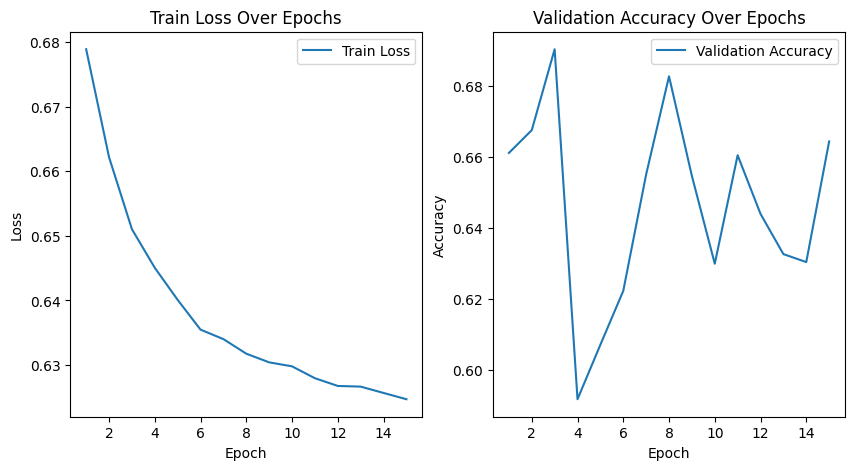

🎯 Final Test Accuracy: 0.6682


In [25]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch_geometric.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from collections import Counter

# ✅ Train the model
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        out = model(data)  # Output shape: (num_nodes, num_classes)
        loss = criterion(out, data.y)  # Cross-entropy loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)

# ✅ Evaluate the model
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)

            correct += (pred == data.y).sum().item()
            total += data.y.size(0)

    return correct / total  # Node-level accuracy

# ✅ Load Protein Dataset
protein_graph_dataset = ProteinGraphDataset(protein_graph_dataset)  # Wrap list into PyG Dataset

# ✅ Split dataset into train/validation/test (70% train, 10% val, 20% test)
train_size = int(0.7 * len(protein_graph_dataset))
val_size = int(0.1 * len(protein_graph_dataset))
test_size = len(protein_graph_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(protein_graph_dataset, [train_size, val_size, test_size])

# ✅ Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ✅ Define Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GATVirtualNode(in_features=protein_graph_dataset[0].x.shape[1], hidden_dim=128, num_heads=4, num_classes=2).to(device)

# **Balanced Class Weights** (based on Counter({0: 1375603, 1: 204152}))
class_weights = torch.tensor([1.0, 1375603 / 204152], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)  # Lowered learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce lr every 5 epochs

model_save_path = "trained_gat_model.pth"

# ✅ Training Loop (with validation & early stopping)
num_epochs = 50
best_val_acc = 0.0
early_stopping = EarlyStopping(patience=5, delta=0.01)

train_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_acc = evaluate(model, val_loader, device)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # ✅ Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_save_path)
        print(f"✅ Model saved at epoch {epoch+1} with accuracy {val_acc:.4f}!")

    scheduler.step()  # Adjust learning rate

    # Check for early stopping (now based on validation loss)
    early_stopping(train_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the best model after training
early_stopping.load_best_model(model)
print("✅ Training Completed!")

# ✅ Plot Loss vs. Accuracy Trends
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train Loss Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy Over Epochs")

plt.show()

# ✅ Final Test Evaluation
test_acc = evaluate(model, test_loader, device)
print(f"🎯 Final Test Accuracy: {test_acc:.4f}")



TESTING BLACKBOX

In [ ]:
import torch
import os
import pandas as pd
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from torch_geometric.data import Data
import torch.nn.functional as F  # Import softmax

# ✅ Load Residue Features from CSV (without labels)
def load_residue_features(csv_path):
    """Loads residue features (without labels) from CSV."""
    df = pd.read_csv(csv_path)
    df.iloc[:, 0] = df.iloc[:, 0].apply(eval)  # Convert "(1, 'L')" → (1, 'L')

    residue_ids = df.iloc[:, 0]  # Residue ID as tuple
    features = df.iloc[:, 1:].values  # Feature columns (WITHOUT label)

    # Create lookup dictionary
    features_dict = {res_id: feat for res_id, feat in zip(residue_ids, features)}

    return features_dict, features.shape[1]  # Return features & number of features

# ✅ Convert NetworkX Graph → PyTorch Geometric Graph
def networkx_to_pyg(G_nx, features_dict, num_features):
    """Converts a NetworkX protein graph to a PyTorch Geometric Data object."""
    node_map = {}
    reverse_map = {}
    node_features = []

    for i, (node, attr) in enumerate(G_nx.nodes(data=True)):
        res_id = (attr.get("residue_number"), attr.get("chain_id"))
        node_map[node] = i
        reverse_map[i] = res_id

        features = features_dict.get(res_id, [0] * num_features)  # Use zero vector if missing
        node_features.append(features)

    x = torch.tensor(node_features, dtype=torch.float)

    edges = [(node_map[u], node_map[v]) for u, v in G_nx.edges() if u in node_map and v in node_map]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index), reverse_map

# ✅ Function to Predict Binding Sites with Probabilities
def predict_binding_sites(model, pdb_path, csv_path, device):
    """Predicts binding sites for a single PDB file using a trained model and returns probabilities."""
    model.eval()

    if not os.path.exists(csv_path):
        print(f"⚠️ No CSV found for {pdb_path}. Skipping!")
        return None

    print(f"📌 Processing {pdb_path}...")

    # Load features
    features_dict, num_features = load_residue_features(csv_path)

    # Construct graph
    config = ProteinGraphConfig(**new_edge_funcs)  # Ensure new_edge_funcs is defined
    G_nx = construct_graph(config=config, path=pdb_path)

    # Convert to PyG format
    protein_graph_data, reverse_map = networkx_to_pyg(G_nx, features_dict, num_features)

    # Move to device
    protein_graph_data = protein_graph_data.to(device)

    # Make prediction
    with torch.no_grad():
        out = model(protein_graph_data)  # Shape: (num_nodes, num_classes)
        probabilities = F.softmax(out, dim=1)[:, 1]  # Probability of class 1 (binding site)

    # Map probabilities to residue IDs
    binding_site_probabilities = {
        reverse_map[i]: float(probabilities[i].item()) for i in range(len(probabilities))
    }

    return binding_site_probabilities

# ✅ Load Trained Model
model_path = "trained_gat_model.pth"  # CHANGE THIS to your model path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load dynamic in_features based on dataset
#pdb_file = "6afj.pdb"  # CHANGE THIS
#csv_file = "6afj.csv"  # CHANGE THIS

# Load residue features to get the correct input size
features_dict, num_features = load_residue_features(csv_file)  # Get correct input size

# ✅ Initialize Model (using correct feature size)
model = GATVirtualNode(
    in_features=num_features, hidden_dim=128, num_heads=4, num_classes=2
).to(device)

# Load the trained model state
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ✅ Inference on a New PDB + CSV (with probabilities)
binding_site_probs = predict_binding_sites(model, pdb_file, csv_file, device)

# ✅ Print Results
if binding_site_probs is not None:
    print("\n🔹 Binding Site Probability Predictions 🔹")
    for residue, prob in binding_site_probs.items():
        print(f"Residue {residue}: Probability of Binding Site = {prob:.4f}")
else:
    print("⚠️ No binding site probabilities to display.")

In [ ]:
DEBUGGING AND OTHER STUFF

In [15]:
!rm -rf /content/protein_graphs  # Remove incorrectly extracted folder
!unzip -o "/content/drive/MyDrive/MÁSTER/SBIPYTPLProject/protein_graphs.zip" -d "/content/"


Archive:  /content/drive/MyDrive/MÁSTER/SBIPYTPLProject/protein_graphs.zip
   creating: /content/protein_graphs/
  inflating: /content/protein_graphs/1g5f.pt  
  inflating: /content/protein_graphs/5ayy.pt  
  inflating: /content/protein_graphs/5gn7.pt  
  inflating: /content/protein_graphs/5ewd.pt  
  inflating: /content/protein_graphs/2ql9.pt  
  inflating: /content/protein_graphs/1lqd.pt  
  inflating: /content/protein_graphs/2mps.pt  
  inflating: /content/protein_graphs/5tl9.pt  
  inflating: /content/protein_graphs/1tsl.pt  
  inflating: /content/protein_graphs/4fns.pt  
  inflating: /content/protein_graphs/5azg.pt  
  inflating: /content/protein_graphs/3sv7.pt  
  inflating: /content/protein_graphs/13gs.pt  
  inflating: /content/protein_graphs/4lxb.pt  
  inflating: /content/protein_graphs/6eq4.pt  
  inflating: /content/protein_graphs/2jjr.pt  
  inflating: /content/protein_graphs/3gqo.pt  
  inflating: /content/protein_graphs/4tw6.pt  
  inflating: /content/protein_graphs/5ew

In [16]:
import os
print("Extracted files:", os.listdir("/content/protein_graphs"))


Extracted files: ['5tkt.pt', '4s3e.pt', '3twr.pt', '3kxz.pt', '3lik.pt', '4ipf.pt', '3muf.pt', '1lt5.pt', '5acx.pt', '1h1b.pt', '5l99.pt', '1cqp.pt', '5d1n.pt', '6cbh.pt', '1oq5.pt', '5bpe.pt', '3t1l.pt', '4drn.pt', '3n2c.pt', '4m5m.pt', '2cbr.pt', '2n0u.pt', '5tbj.pt', '4bbe.pt', '4k72.pt', '2jk9.pt', '4fe9.pt', '2x4s.pt', '5mri.pt', '4lq9.pt', '5l4f.pt', '3qlc.pt', '3vi5.pt', '1guw.pt', '4pz5.pt', '3wk8.pt', '2uw3.pt', '5wbr.pt', '3at1.pt', '2hd6.pt', '1z3j.pt', '5tzx.pt', '5qaz.pt', '5khi.pt', '6b30.pt', '1lhg.pt', '5tl9.pt', '5alm.pt', '3bxs.pt', '4iu0.pt', '3agm.pt', '4c5w.pt', '2oph.pt', '4qr5.pt', '3zpt.pt', '4bfz.pt', '6qae.pt', '4e49.pt', '3mxc.pt', '1m5f.pt', '1i80.pt', '5i22.pt', '4o75.pt', '1rpa.pt', '6eea.pt', '1mqd.pt', '3tkz.pt', '3chp.pt', '3s9t.pt', '6eo8.pt', '3vb7.pt', '3g76.pt', '5g11.pt', '4ii9.pt', '4rx5.pt', '6cvx.pt', '6mm5.pt', '1zaj.pt', '3kyg.pt', '6f6u.pt', '1swk.pt', '3plu.pt', '1tog.pt', '4b6e.pt', '5tnt.pt', '1rek.pt', '1agm.pt', '3twx.pt', '5nmg.pt', '5j

CHECKING FOR CLASS IMABLANCE

In [21]:
from collections import Counter
labels = [data.y.tolist() for data in protein_graph_dataset]
flattened_labels = [y for sublist in labels for y in sublist]
print(Counter(flattened_labels))  # Show class counts

<ipython-input-18-6cdf9eafee65>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(self.graph_files[idx])  # Load graph from disk


Counter({0: 1375603, 1: 204152})
